In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import kstest

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_excel('resultsА_B.xlsx')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [4]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [5]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [7]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

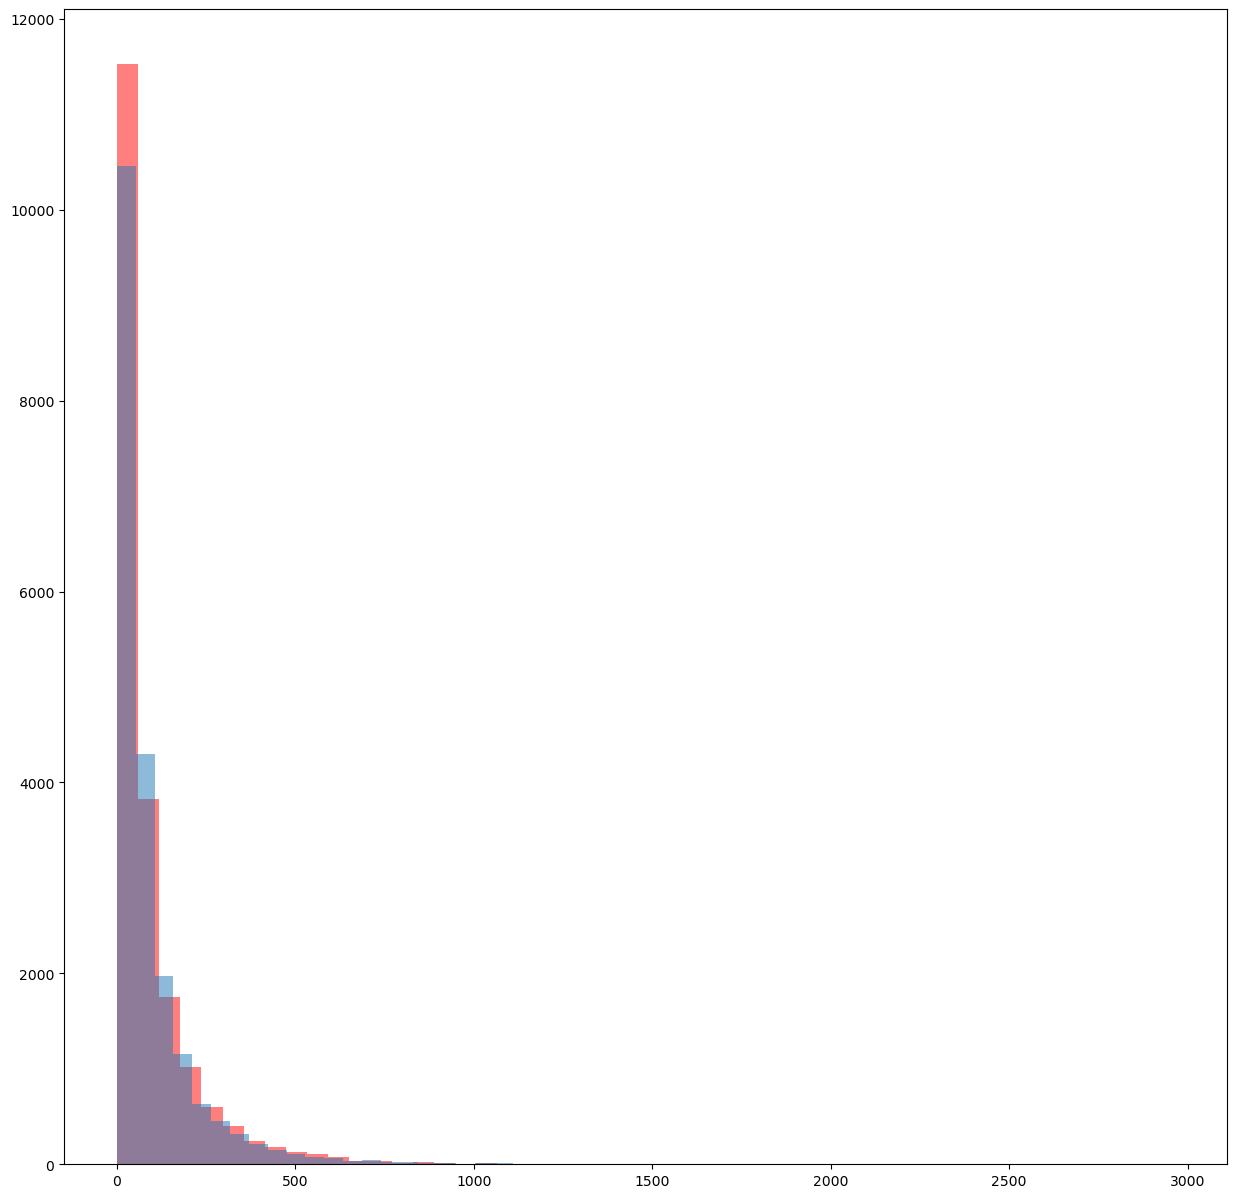

In [8]:
plt.figure(figsize=(15, 15))
control_revenue_1 = df['sum_gamerounds'][(df['version'] == 'gate_30') & (df['retention_1'] == 1)]
test_revenue_1 = df['sum_gamerounds'][(df['version'] == 'gate_40') & (df['retention_1'] == 1)]

plt.hist(control_revenue_1, color='r', bins=50, alpha = 0.5)
plt.hist(test_revenue_1, bins=50, alpha = 0.5)

plt.show()

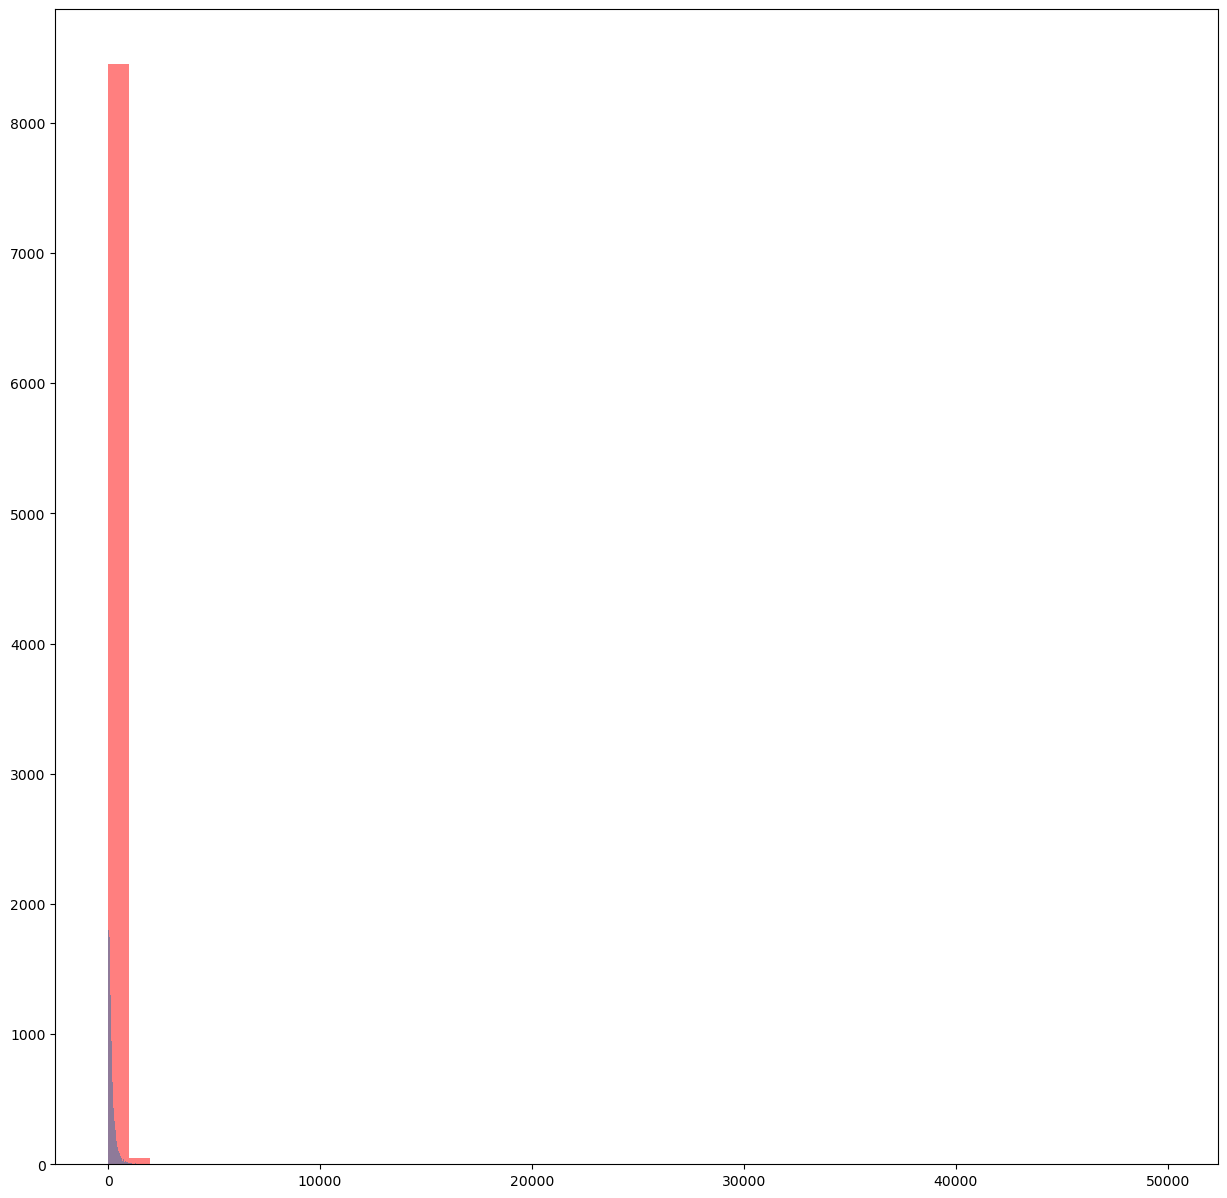

In [9]:
plt.figure(figsize=(15, 15))
control_revenue_7 = df['sum_gamerounds'][(df['version'] == 'gate_30') & (df['retention_7'] == 1)]
test_revenue_7 = df['sum_gamerounds'][(df['version'] == 'gate_40') & (df['retention_7'] == 1)]

plt.hist(control_revenue_7, color='r', bins=50, alpha = 0.5)
plt.hist(test_revenue_7, bins=50, alpha = 0.5)

plt.show()

In [10]:
mannwhitneyu(control_revenue_1, test_revenue_1)

MannwhitneyuResult(statistic=201099475.5, pvalue=0.7095456166954823)

In [11]:
mannwhitneyu(control_revenue_7, test_revenue_7)

MannwhitneyuResult(statistic=34390976.0, pvalue=0.01048030954207341)

In [12]:
ttest_ind(control_revenue_1, test_revenue_1, equal_var = False)

Ttest_indResult(statistic=-0.7117711753685567, pvalue=0.4766106213044483)

In [13]:
ttest_ind(control_revenue_7, test_revenue_7, equal_var = False)

Ttest_indResult(statistic=0.04822623864191983, pvalue=0.9615368736712436)

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

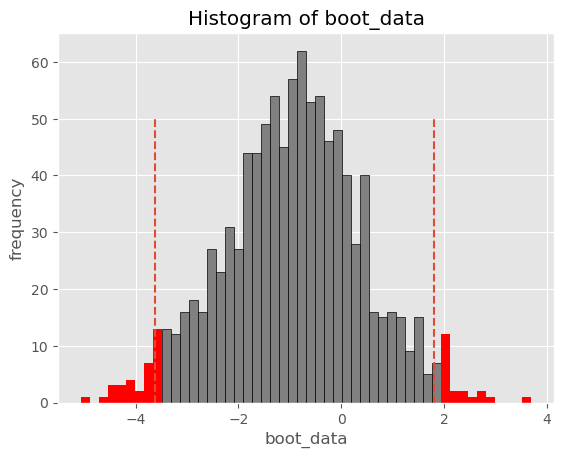

{'p_value': 0.48775626007457884}

In [15]:
get_bootstrap(control_revenue_1, test_revenue_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

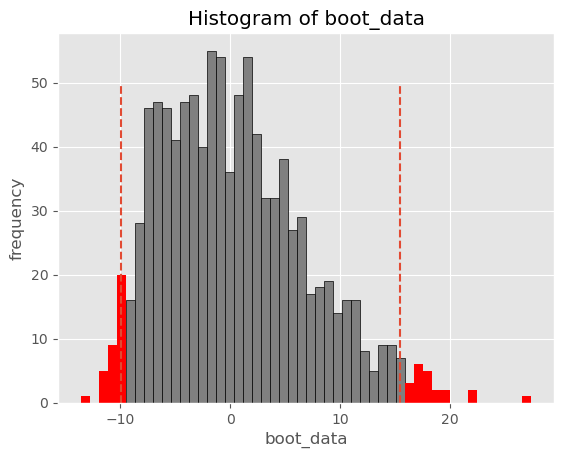

{'p_value': 0.95887533749667}

In [16]:
get_bootstrap(control_revenue_7, test_revenue_7)

Принимая за нулевую гипотезу размещение ворот на 30м уровне, и т-тест, и тест Манна-Уитни, а также метод бутстрепа, дают нам понять, что перемещение ворот на 40й уровень не даёт статистически значимых отличий. Ниже проверим их графической реализацией бутстрепа с kaggle.

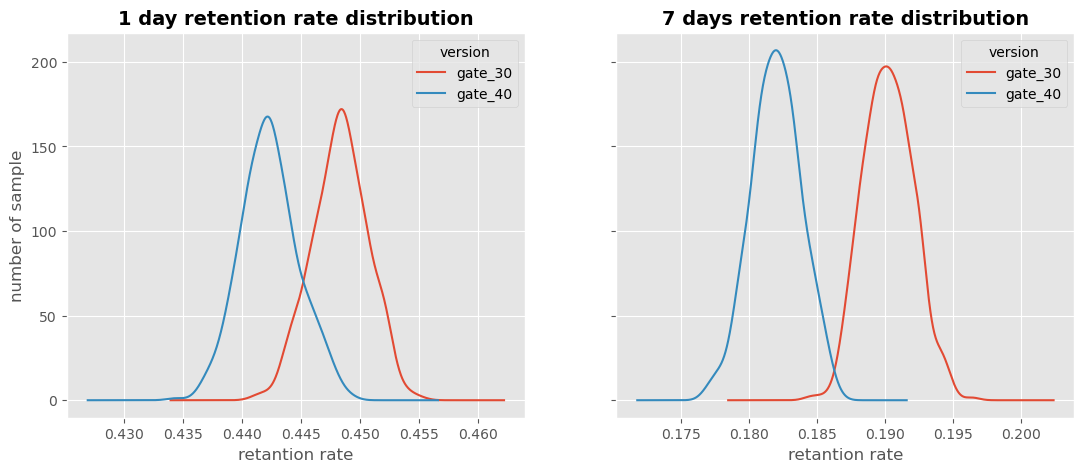

In [17]:
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

Распределение retention за один день и за семь дней выше для версии, когда ворота на 30м уровне, а значит тестовую гипотезу стоит отвергнуть.